# Collaborative Filtering for Movie Recommendations

**Description:** Recommending movies using a model trained on Movielens dataset.

## Introduction

This example demonstrates
[Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering)
using the [Movielens dataset](https://www.kaggle.com/c/movielens-100k)
to recommend movies to users.
The MovieLens ratings dataset lists the ratings given by a set of users to a set of movies.
Our goal is to be able to predict ratings for movies a user has not yet watched.
The movies with the highest predicted ratings can then be recommended to the user.

The steps in the model are as follows:

1. Map user ID to a "user vector" via an embedding matrix
2. Map movie ID to a "movie vector" via an embedding matrix
3. Compute the dot product between the user vector and movie vector, to obtain
the a match score between the user and the movie (predicted rating).
4. Train the embeddings via gradient descent using all known user-movie pairs.
5. Compute a match score between the user and the movie using a 3 layer multi-layer perceptron

**References:**

- [Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/371920.372071)
- [Neural Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/3038912.3052569)

In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from zipfile import ZipFile

import keras
from keras import layers
from keras import ops


## First, load the data and apply preprocessing

In [ ]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file("ml-latest-small.zip", movielens_data_file_url, extract=False
                                             )
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

First, need to perform some preprocessing to encode users and movies as integer indices.

In [ ]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


## Prepare training and validation data

In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

## Create the model

We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product,
and adds a per-movie and per-user bias. The match score is scaled to the `[0, 1]`
interval via a sigmoid (since our ratings are normalized to this range).

In [ ]:
# Why embeddings? Embeddings help the model learn a compact representation for users and movies rather than directly using the user and movie IDs, which are sparse
# Why bias? Bias for users account for their tendency to give varying ratings while bias for movies account for their tendency to get higher or lower ratings

EMBEDDING_SIZE = 50 # Represents users and movies as 50-dimensional vectors

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users # Total number of users in the dataset
        self.num_movies = num_movies # Total number of movies in the dataset
        self.embedding_size = embedding_size # Total size of users and movie vectors

        # User embedding layer maps each user ID to a unique 50-dimensional vector
        self.user_embedding = layers.Embedding(
            num_users, # Number of unique users
            embedding_size, # Length of the vector for each user
            embeddings_initializer="he_normal", # Initial weights
            embeddings_regularizer=keras.regularizers.l2(1e-6), # Regularization to prevent overfitting
        )

        # This layer adds a unique bias term for each user (sort of like reference)
        self.user_bias = layers.Embedding(num_users, 1)

        # Movie embedding layer maps each movie to a unique 50-dimensional vector
        self.movie_embedding = layers.Embedding(
            num_movies, # Number of unique movies
            embedding_size, # Length of the vector for each movie
            embeddings_initializer="he_normal", # Initial weights
            embeddings_regularizer=keras.regularizers.l2(1e-6), # Regularization to prevent overfitting
        )

        # This layer adds a unique bias term for each movie, showing its popularity
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        # Splits inputs into user IDs and movie IDs
        user_vector = self.user_embedding(inputs[:, 0]) # Find the user's vector representation
        user_bias = self.user_bias(inputs[:, 0]) # Get the bias for the user
        movie_vector = self.movie_embedding(inputs[:, 1]) # Find the movie's vector representation
        movie_bias = self.movie_bias(inputs[:, 1]) # Get the bias for the movie

        # Dot product in order to compute how much the user likes the movie (how aligned the user and movie vectors are)
        dot_user_movie = ops.tensordot(user_vector, movie_vector, 2) # A single number that shows user and movie match

        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias

        # The sigmoid activation forces the rating to between 0 and 1, while also introducing non-linearity (which helps the model learn complex patterns in the data)
        return ops.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

## Train the model based on the data split

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6575 - val_loss: 0.6201
Epoch 2/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6150 - val_loss: 0.6180
Epoch 3/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6093 - val_loss: 0.6126
Epoch 4/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6082 - val_loss: 0.6125
Epoch 5/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6079 - val_loss: 0.6127


## Plot training and validation loss

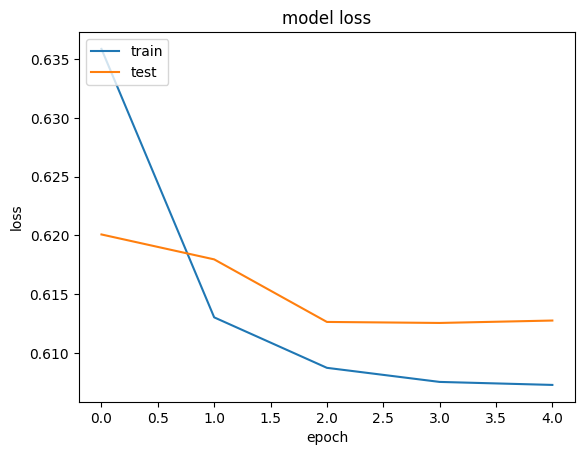

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Show top 10 movie recommendations to a user

In [ ]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Showing recommendations for user: 66
Movies with high ratings from user
--------------------------------
Don Juan DeMarco (1995) : Comedy|Drama|Romance
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) : Action|Adventure|Western
Little Big Man (1970) : Western
Five Easy Pieces (1970) : Drama
Memento (2000) : Mystery|Thriller
--------------------------------
Top 10 movie recommendations
--------------------------------
Schindler's List (1993) : Drama|War
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Godfather, The (1972) : Crime|Drama
Rear Window (1954) : Mystery|Thriller
One Flew Over the Cuckoo's Nest (1975) : Drama
Lawrence of Arabia (1962) : Adventure|Drama|War
Apocalypse Now (1979) : Action|Drama|War
L.A. Confidential (1997) : Crime|Film-Noir|Mystery|Thriller
Snatch (2000) : Comedy|Crime|Thriller
City of God (Cidade de Deus) (2002) : Action|Adventure|Crime|Drama|Thriller


In [ ]:
# Denormalize predictions and targets
y_pred = model.predict(x_val).flatten()
y_pred_denorm = y_pred * (max_rating - min_rating) + min_rating
y_val_denorm = y_val * (max_rating - min_rating) + min_rating

rmse = np.sqrt(mean_squared_error(y_val_denorm, y_pred_denorm))
print("RMSE:", rmse)

316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE: 0.9734118109605356


# Use 3 layer MLP instead of dot product



In [ ]:
# Change dot product to 3 layers MLP
EMBEDDING_SIZE = 50


class RecommenderNetMLP(keras.Model):
    # Class constructor
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        # Declare user embedding
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Declare user bias
        self.user_bias = layers.Embedding(num_users, 1)
        # Declare movie embedding
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Declare movie bias
        self.movie_bias = layers.Embedding(num_movies, 1)
        # 3 layer MLP
        self.mlp = keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu'),
            layers.Dense(1) # Output layer
        ])


    def call(self, inputs):
        # Getting information about user & movie
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        x = layers.concatenate([user_vector, movie_vector])

        x = self.mlp(x)

        # Add all the components (including bias)
        x = x + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return ops.nn.sigmoid(x)

In [ ]:
model = RecommenderNetMLP(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
)

In [ ]:
training_log1 = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6366 - val_loss: 0.6057
Epoch 2/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.5951 - val_loss: 0.6015
Epoch 3/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5880 - val_loss: 0.6008
Epoch 4/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.5859 - val_loss: 0.6000
Epoch 5/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5822 - val_loss: 0.5997


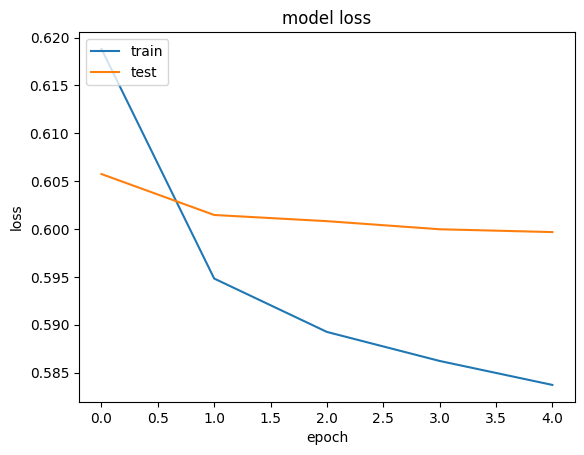

In [ ]:
plt.plot(training_log1.history["loss"])
plt.plot(training_log1.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
# user_id = df.userId.sample(1).iloc[0]
user_id = 606
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Showing recommendations for user: 606
Movies with high ratings from user
--------------------------------
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Breakfast at Tiffany's (1961) : Drama|Romance
My Fair Lady (1964) : Comedy|Drama|Musical|Romance
Wings of Desire (Himmel über Berlin, Der) (1987) : Drama|Fantasy|Romance
Manhattan (1979) : Comedy|Drama|Romance
--------------------------------
Top 10 movie recommendations
--------------------------------
Streetcar Named Desire, A (1951) : Drama
Paths of Glory (1957) : Drama|War
Lifeboat (1944) : Drama|War
Yojimbo (1961) : Action|Adventure
Double Indemnity (1944) : Crime|Drama|Film-Noir
Jonah Who Will Be 25 in the Year 2000 (Jonas qui aura 25 ans en l'an 2000) (1976) : Comedy
Trial, The (Procès, Le) (1962) : Drama
Day of the Doctor, The (2013) : Adventure|Drama|Sci-Fi
Captain Fantastic (2016) : Drama
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama


In [ ]:
# Denormalize predictions and targets
y_pred = model.predict(x_val).flatten()
y_pred_denorm = y_pred * (max_rating - min_rating) + min_rating
y_val_denorm = y_val * (max_rating - min_rating) + min_rating

rmse = np.sqrt(mean_squared_error(y_val_denorm, y_pred_denorm))
print("RMSE:", rmse)

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE: 0.8688513103953605


# Summary

The average prediction error improved around 10.5% from the dot product to the 3 layer MLP